## ## A/B Testing Part 2  :  Bootstrap resampling 

--------

In [1]:
# ref 
# https://github.com/yennanliu/hackermath/blob/master/Module_2f_ABTesting.ipynb
# https://github.com/omoju/Fundamentals/blob/master/Data/data_Stats_4_ABTesting.ipynb


In [2]:
# Import libraries
from __future__ import absolute_import, division, print_function

# Ignore warnings
import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('tools/')

# OP 
import pandas as pd
import numpy as np
#from scipy import stats
import scipy.stats as st
%matplotlib inline
%pylab inline
import seaborn  as sns 
#import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
from matplotlib import pyplot
import matplotlib as mpl
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [3]:

# set plot style
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

In [4]:
# help func 

def axis_tick_frequency(ax, axis, freq):
    """The frequency of the y axis tick marks
        Attributes
        ----------
        ax: matplotlib axis object
        axis: char eithher 'y' or 'x'
        freq: int, the integer value of which the range moves
    """
    
    if axis == 'y':
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, freq))
    elif axis == 'x':
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, freq))
    else:
        raise ValueError('{argument} is not a valid axis object'.format(argument=repr(axis)))
        
        
    
def sample(num_sample, top, with_replacement=False):
    """
    Create a random sample from a table
    
    Attributes
    ---------
    num_sample: int
    top: dataframe
    with_replacement: boolean
    
    Returns a random subset of table index
    """
    df_index = []
    lst = np.arange(0, len(top), 1)

    for i in np.arange(0, num_sample, 1):

        # pick randomly from the whole table
        sample_index = np.random.choice(lst)

        if with_replacement:
            # store index
            df_index.append(sample_index)
        else:
            # remove the choice that was selected
            lst = np.setdiff1d(lst,[sample_index])
            df_index.append(sample_index)
            
    return df_index
    

## 0) Load data

In [14]:
# titanic dataset 
# https://www.kaggle.com/c/titanic/data#

df=pd.read_csv('train.csv')

In [8]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116924a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116a73240>]], dtype=object)

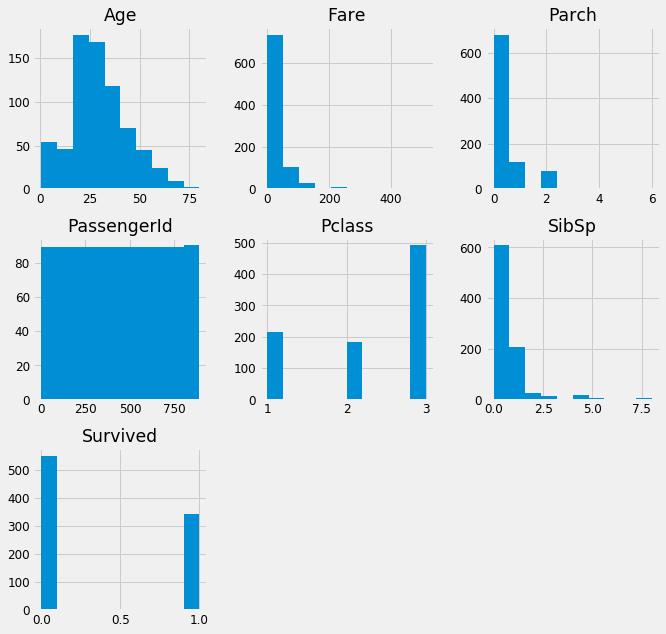

In [9]:
df.hist()

## 1 ) Is "survived or not survived" associated  with fare  ?

In [10]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [21]:
df[df.Survived==1.0 ].head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


Text(0.5,1,'Fare histgram : Survived VS. non-Survived group  ')

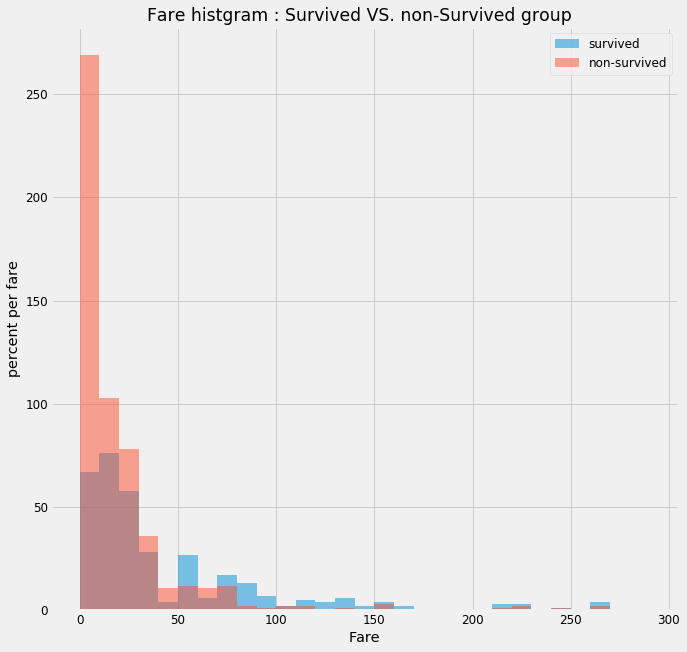

In [32]:
# visualize Fare on Survived & non-Survived group 
df[df.Survived==1.0 ]['Fare'].hist(alpha=.5,bins=np.arange(0, 300, 10))
df[df.Survived==0.0 ]['Fare'].hist(alpha=.5,bins=np.arange(0, 300, 10))
plt.legend(["survived","non-survived" ])
pyplt.ylabel("percent per fare")
pyplt.xlabel("Fare")
plt.title('Fare histgram : Survived VS. non-Survived group  ')

Both distributions are skew shaped while the "survived" group is 
with median ~ fare 26.0 ; the "non-survived" group is with median ~ fare 10.5. We can nearly say  *** The distributions are not identical. ***
But then it raises another question : *** whether the difference ("survived" and "non-survived") reflects just chance variation or a difference in the distributions in the population. ***


So we have set up "Hypothesis Test"  

> * Null hypothesis (N0):  The difference in the sample is due to chance.
i.e. The distribution of fare of "survived group" is the same for "non survived group" 
> * Alternative hypothesis(N1): The two distributions are different in the population.
> * Test statistic: T test


## 2) Hypothesis Test

In [33]:
a = df[df.Survived==1.0 ]['Fare'].values
b = df[df.Survived==0.0 ]['Fare'].values

In [39]:
# mean value table 

raw = {
        'Survived': [True, False],
        'Fare mean': [a.mean(), b.mean()]
}
means_table = pd.DataFrame(raw)
means_table

,Fare mean,Survived
0,48.395408,True
1,22.117887,False


In [36]:
# difference in the means
a.mean() - b.mean()

26.277520717093282

In [37]:
# t-test 
statistic, pvalue = st.ttest_ind(a, b)
print ('T statistic: %.2f'%statistic,'\nP-value:%.2f'%pvalue)


T statistic: 7.94 
P-value:0.00


> The P-value (0.00) is super small. As a result, we can reject the Null hypothesis (N0) and conclude that in the population, the distribution of 
"survived" and "non-survived" are different.




## 3) Bootstrap Confidence Interval For the Difference

Our hypothesis Test (via t-test) conclude that the 2 distributions 
are 2 different with very high possibility.
But, in general cases, the difference above maybe is due to "randomness".
To avoid the "randomness affects", we need to generate more samples
via the the "Bootstrap resampling" tricks here. (It simply replicates the original random sample and computes new values of the statistic.)

PS. However maybe it not 100% sense to re-sample on the titanic dataset,
since they may only happen once lol.


